In [1]:
from __future__ import print_function
import csv
import math
import sys
import cv2
import os
from sklearn.metrics import f1_score
from pathlib import Path
from keras import optimizers
import numpy as np
from keras.models import load_model
import time
from unet import *
from data import *
from keras.models import Model
from keras.callbacks import ModelCheckpoint, CSVLogger
import keras.backend as K
K.set_image_data_format('channels_last')

In [2]:
def recall_m(y_true, y_pred):
    y_pred = K.reshape(y_pred, shape=(
        (K.shape(y_pred)[0]*K.shape(y_pred)[1]*K.shape(y_pred)[2]), num_classes))
    y_true = K.reshape(y_true, shape=(
        (K.shape(y_true)[0]*K.shape(y_true)[1]*K.shape(y_true)[2]), num_classes))
    # without background. Last class should be background
    true_positives = K.sum(
        K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)[0:-1])
    # without background. Last class should be background
    possible_positives = K.sum(
        K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)[0:-1])
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    y_pred = K.reshape(y_pred, shape=(
        (K.shape(y_pred)[0]*K.shape(y_pred)[1]*K.shape(y_pred)[2]), num_classes))
    y_true = K.reshape(y_true, shape=(
        (K.shape(y_true)[0]*K.shape(y_true)[1]*K.shape(y_true)[2]), num_classes))
    # without background. Last class should be background
    true_positives = K.sum(
        K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)[0:-1])
    # without background. Last class should be background
    predicted_positives = K.sum(
        K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)[0:-1])
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def fscore(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall + K.epsilon()))


def jaccard_distance_loss(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


def fscore1(y_true, y_pred):
    y_true = y_true[:, :, :, :-1]
    y_pred = y_pred[:, :, :, :-1]
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    true_positives = K.sum(K.round(y_true * y_pred))
    predicted_positives = K.sum(K.round(y_pred))
    possible_positives = K.sum(K.round(y_true))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f_score1 = 2*((precision*recall)/(precision+recall + K.epsilon()))
    return f_score1

In [3]:
data_gen_train = dict(rotation_range=10,
                      horizontal_flip=True,
                      width_shift_range=5,
                      height_shift_range=5,
                      vertical_flip=False,
                      fill_mode='nearest')

path =os.getcwd()

path = Path(path)

print(path)


# path1 = Path("/mnt/smiledata/shajahan_trails/Weights")
path1 = Path("/Weights")


magnification = "4x"
if sys.argv[1:]:
    magnification = sys.argv[1]

# val_name = path/"Data_keras"/magnification/"val"
# train_name = path/"Data_keras"/magnification/"train"
# csv_name = path/"Results/CSV"/magnification/"training_4x.csv"
# weights_folder = path1/magnification/"weights"
# model_name = path/"Modelh5/core_model.h5"

val_name = path/"data_keras/val/"
train_name = path/"data_keras/train/"
csv_name = "Results/CSV/training_4x.csv"
weights_folder = path/"Weights/4x/weights"
model_name = "Modelh5/core_model.h5"


batch_size = 4  # No. of images in a batch
size = 512
# weights_40x = [0.979, 0.947, 0.929, 0.982, 0.164]
# weights_10x = [0.967, 0.96, 0.88, 0.974, 0.219]

# weights_4x = {0:0.967, 1:0.969, 2:0.887, 3:0.969, 4:0.208}


# weights = weights_4x

print("hello train name",train_name)


print(os.listdir(train_name))

from IPython.display import Image, display

listOfImageNames = os.listdir(train_name/"images")
print(listOfImageNames)

# i =0
# for imageName in listOfImageNames:
#     if i ==0:
#         print("brrr")
#         print()

#     else:
#         display(Image(filename=train_name/"images"/imageName))
#         print()

#     i= i+1
#     # print(i)

print(train_name)
num_images = num_of_images(train_name)


/Users/shashanksk/Desktop/problem recomender/fromgithub/Fundus-of-eye-classification
hello train name /Users/shashanksk/Desktop/problem recomender/fromgithub/Fundus-of-eye-classification/data_keras/train
['.DS_Store', 'images', 'mask']
['40_training.png', '24_training.png', '31_training.png', '36_training.png', '.DS_Store', '37_training.png', '30_training.png', '25_training.png', '28_training.png', '29_training.png', '39_training.png', '38_training.png', '32_training.png', '35_training.png', '27_training.png', '26_training.png', '34_training.png', '33_training.png']
/Users/shashanksk/Desktop/problem recomender/fromgithub/Fundus-of-eye-classification/data_keras/train
Found 17 images belonging to 1 classes.


In [4]:
# val_x, val_y, img_name = validation(
#     str(val_name/"images"), str(val_name/"mask")) i commentd



# display(Image(filename=val_name/"images/32_manual1.png"))

val_x, val_y, img_name = validation(
    str(val_name/"images"), str(val_name/"mask"))




train = dataGenerator(batch_size, train_name, data_gen_train, size)
loss_fn = 'categorical_crossentropy'
batch_steps = np.ceil(num_images / batch_size)
sgd = optimizers.SGD(lr=1e-6, decay=1e-6, momentum=0.9, nesterov=True)
rms = optimizers.RMSprop(lr=1e-4)
#opt = 'adam'
opt = rms

if os.path.isdir(weights_folder) is not True:
    os.mkdir(weights_folder)

csv_logger = CSVLogger(csv_name, append=True)
# ,save_best_only=True,monitor='val_fscore',mode='max')
checkpointer = ModelCheckpoint(
    filepath='%s/weights.{epoch:03d}.hdf5' % weights_folder, save_weights_only=True) 
start = time.time()


checkpoint_path = str(model_name)

checkpoint_path = None

if checkpoint_path is not None:
    model = load_model(checkpoint_path, custom_objects={'fscore': fscore})
    # To continue from a particular epoch
    model.load_weights("%s/weights.001.hdf5" % str(weights_folder)) 
    initial_epoch = 0
else:
    model = build_model(input_shape=(None, None, 3),
                        preset_model="MobileUNet-Skip", num_classes=num_classes)
    initial_epoch = 0

final_epoch = 15
print(model.summary())
model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy', fscore])

# model.fit_generator(train, steps_per_epoch=batch_steps, epochs=final_epoch, verbose=1, validation_data=(
#     val_x, val_y), validation_steps=None,  callbacks=[csv_logger, checkpointer], shuffle=True, class_weight=weights, initial_epoch=initial_epoch)
# i commeted

model.fit(train, steps_per_epoch=batch_steps, epochs=final_epoch, verbose=1, validation_data=(
    val_x, val_y), validation_steps=None,callbacks=[csv_logger, checkpointer], shuffle=True, class_weight=None, initial_epoch=initial_epoch)



model.save(str(model_name))
end = time.time()
print(
    f"time taken for training {final_epoch - initial_epoch} is {end - start} seconds")


['/Users/shashanksk/Desktop/problem recomender/fromgithub/Fundus-of-eye-classification/data_keras/val/images/23_training.png', '/Users/shashanksk/Desktop/problem recomender/fromgithub/Fundus-of-eye-classification/data_keras/val/images/22_training.png', '/Users/shashanksk/Desktop/problem recomender/fromgithub/Fundus-of-eye-classification/data_keras/val/images/21_training.png']


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "MobileUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   1792        ['zero_padding2d[0][0]']         
                                64)                                                      

2022-06-20 15:44:59.133184: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 55s 10s/step - loss: 0.3345 - accuracy: 0.6113 - fscore: 0.0056 - val_loss: 0.5715 - val_accuracy: 0.7992 - val_fscore: 0.0000e+00
Epoch 2/15
5/5 [==============================] - 57s 10s/step - loss: 0.2560 - accuracy: 0.6422 - fscore: 0.0094 - val_loss: 0.5702 - val_accuracy: 0.7992 - val_fscore: 0.0000e+00
Epoch 3/15
5/5 [==============================] - 49s 9s/step - loss: 0.2333 - accuracy: 0.6447 - fscore: 0.0089 - val_loss: 0.5691 - val_accuracy: 0.7992 - val_fscore: 0.0000e+00
Epoch 4/15
5/5 [==============================] - 56s 11s/step - loss: 0.2216 - accuracy: 0.6430 - fscore: 0.0103 - val_loss: 0.5680 - val_accuracy: 0.7992 - val_fscore: 0.0000e+00
Epoch 5/15
5/5 [==============================] - 61s 11s/step - loss: 0.2134 - accuracy: 0.6422 - fscore: 0.0123 - val_loss: 0.5672 - val_accuracy: 0.7992 - val_fscore: 0.0000e+00
Epoch 6/15
5/5 [==============================] - 51s 10s/step - loss: 0.2064 - accuracy: 0.6429 - fscore: 

5/5 [==============================] - 10s 2s/step


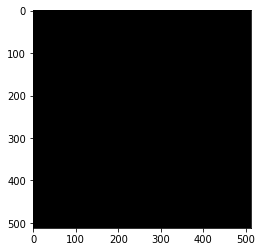

[[[0.48594093 0.51405907]
  [0.48702967 0.5129703 ]
  [0.48714748 0.5128525 ]
  ...
  [0.48705545 0.51294464]
  [0.4870849  0.51291513]
  [0.48729235 0.51270765]]

 [[0.48628148 0.5137185 ]
  [0.48748314 0.5125169 ]
  [0.48750976 0.5124902 ]
  ...
  [0.4874839  0.51251614]
  [0.4873291  0.51267093]
  [0.48686787 0.5131321 ]]

 [[0.4862463  0.51375365]
  [0.48727965 0.51272035]
  [0.4877612  0.5122388 ]
  ...
  [0.48722827 0.51277167]
  [0.4876961  0.51230395]
  [0.4867852  0.5132148 ]]

 ...

 [[0.4863997  0.5136003 ]
  [0.48730713 0.5126929 ]
  [0.48749402 0.512506  ]
  ...
  [0.4873738  0.5126263 ]
  [0.4872839  0.51271605]
  [0.48686507 0.5131349 ]]

 [[0.48626187 0.51373816]
  [0.48724282 0.51275724]
  [0.487756   0.51224405]
  ...
  [0.48716488 0.5128351 ]
  [0.48770764 0.5122923 ]
  [0.48668525 0.5133147 ]]

 [[0.48556125 0.5144387 ]
  [0.48485634 0.51514363]
  [0.4852952  0.51470476]
  ...
  [0.48489782 0.5151022 ]
  [0.4851897  0.51481026]
  [0.4844464  0.5155536 ]]]


In [8]:
import matplotlib.pyplot as plt
model = load_model("Modelh5/core_model.h5", custom_objects={'fscore': fscore})
model.load_weights("%s/weights.015.hdf5" % str(weights_folder)) 

def colour_code(image, label_values):
    x = np.argmax(image, axis = -1)
    colour_codes = np.array(label_values)
    x = colour_codes[x.astype(int)]
    return x
what = model.predict(train,steps=5)

z = colour_code(what,label_values)
# for i in range(len(z)):
#     a = img_name[i]
#     image_name = os.path.basename(a)
#     print(image_name)
#     out = z[i]
#     inp = val_y[i]
#     image_name = image_name[:image_name.index('.')] 
#     save_img('%s/%s_pred.png'%(output_folder,image_name), out)
#     save_img('%s/%s_%s.png'%(output_folder,image_name,img_type), inp)
# end = time.time()


# print(f"time taken for { len(z) } images is {end - start} seconds ")
plt.imshow(z[0])
plt.show()
# what = model.predict(val_x)
print(what[0])

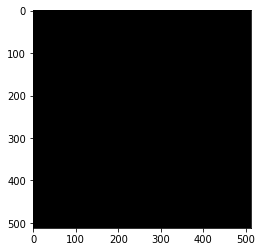

In [12]:
for i in range (0..10):
    plt.imshow(z[i])
    plt.show()
# what = model.predict(val_x)
# print(what[5])